Źrodło danych: https://archive.ics.uci.edu/dataset/33/dermatology

Ta baza danych zawiera 34 atrybuty, z których 33 mają wartości liniowe, a jeden jest nominalny.
Różnicowa diagnoza chorób erytematyczno-łuszczycowych jest rzeczywistym problemem w dermatologii. 
Wszystkie one mają wspólne cechy kliniczne (zaczerwienienie i łuszczenie), z bardzo małymi różnicami. 
Choroby w tej grupie to łuszczyca, łojotokowe zapalenie skóry, liszaj płaski, łupież różowy, przewlekłe zapalenie skóry i łupież rubra mieszkowy. 
Zazwyczaj do diagnozy konieczna jest biopsja, ale niestety te choroby mają także wiele wspólnych cech histopatologicznych. 
Kolejnym utrudnieniem dla różnicowej diagnozy jest to, że choroba może wykazywać cechy innej choroby na początkowym etapie, 
a następnie charakterystyczne cechy na kolejnych etapach. Pacjenci zostali najpierw ocenieni klinicznie pod kątem 12 cech. 
Następnie pobrano próbki skóry do oceny 22 cech histopatologicznych. Wartości cech histopatologicznych są określane przez analizę próbek pod mikroskopem.
W zestawie danych skonstruowanym dla tej dziedziny, cecha historii rodzinnej ma wartość 1, 
jeśli jakiekolwiek z tych chorób zostało zaobserwowane w rodzinie, a 0 w przeciwnym razie. 
Cecha wieku po prostu reprezentuje wiek pacjenta. Każda inna cecha (kliniczna i histopatologiczna) została przypisana stopniowi w zakresie od 0 do 3. 
Tutaj 0 oznacza, że cecha nie była obecna, 3 oznacza największą możliwą ilość, a 1, 2 wskazują na wartości pośrednie względem siebie.

Nazwy i numery identyfikacyjne pacjentów zostały niedawno usunięte z bazy danych.

# 

Import potrzebnych bibliotek

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

Wczytanie danych z pliku

In [ ]:
# Ścieżka do pliku
file_path = "data/dermatology.data" 

# Nazwy kolumn w kolejności według numerów
column_names = [
    "erythema",
    "scaling",
    "definite_borders",
    "itching",
    "koebner_phenomenon",
    "polygonal_papules",
    "follicular_papules",
    "oral_mucosal_involvement",
    "knee_and_elbow_involvement",
    "scalp_involvement",
    "family_history",
    "melanin_incontinence",
    "eosinophils_in_the_infiltrate",
    "PNL_infiltrate",
    "fibrosis_of_the_papillary_dermis",
    "exocytosis",
    "acanthosis",
    "hyperkeratosis",
    "parakeratosis",
    "clubbing_of_the_rete_ridges",
    "elongation_of_the_rete_ridges",
    "thinning_of_the_suprapapillary_epidermis",
    "spongiform_pustule",
    "munro_microabcess",
    "focal_hypergranulosis",
    "disappearance_of_the_granular_layer",
    "vacuolisation_and_damage_of_basal_layer",
    "spongiosis",
    "saw_tooth_appearance_of_retes",
    "follicular_horn_plug",
    "perifollicular_parakeratosis",
    "inflammatory_monoluclear_inflitrate",
    "band_like_infiltrate",
    "age",
    "class"  # Ostatnia kolumna reprezentuje klasę/chorobę (1-6)
]

# Ze względu na strukturę pliku można użyć funkcji read_csv
df = pd.read_csv(file_path, header=None, names=column_names)

# Wyświetlenie całego DataFrame
df


Zamiana znaków "?" na wartości NaN

In [ ]:
df.replace("?", float("NaN"), inplace=True)

df

Sortowanie według wieku rosnąco (wiek jako tekst) w celu lepszej wizualizacji danych na wykresie

In [ ]:
df = df.sort_values(by='age')

Wyświetlenie statystyk opisowych dla każdej kolumny

In [ ]:
df.describe()

Histogram dla kolumny Age

In [ ]:
plt.figure(figsize=(16, 8))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Rozkład wieku pacjentów')
plt.xlabel('Wiek')
plt.ylabel('Liczność')
plt.show()

Wykres pudełkowy (box plot) dla cechy Age w zależności od klasy

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='class', y='age', data=df)
plt.title('Rozkład wieku pacjentów dla różnych diagnoz')
plt.xlabel('Diagnoza')
plt.ylabel('Wiek')
plt.show()

Znajdowanie pustych wartości w całym DataFrame

In [ ]:
missing_values = df.isna().sum()

missing_values

Można zauważyć, że tylko w kolumnie age brakuje wieku dla paru osób. Jest to około 2% wszystkich rekordów. Można w tym wypadku uzupełnić brakujące wartości, na przykład medianą.

In [ ]:
# Wypełnienie brakujących wartości medianą wieku
age_median = df['age'].median()
df['age'].fillna(age_median, inplace=True)

Zamiana wartości Age na typ całkowity (żeby przygotować dane do dalszych obliczeń) i ponowne sortowanie.

In [ ]:
# Zamiana wartości Age na int
df['age'] = df['age'].astype(int)

# Ponowne sortowanie według Age
df = df.sort_values(by='age')

# Wyświetlenie DataFrame po sortowaniu
df

Sprawdźmy, które cechy mają najwyższą korelację z klasą.

In [ ]:
# Obliczenie macierzy korelacji między cechami a klasą
correlations = df.corr()['class'].drop('class')

# Wybranie cech, które mają największą korelację z klasą
selected_features = correlations.abs().nlargest(24).index.tolist()

# Wyświetlenie cech i ich korelacji z klasą
print(correlations[selected_features])

Zajmijmy się teraz normalizacją danych w naszym DataFrame.

In [ ]:
# Inicjalizacja obiektu normalizacji Min-Max
scaler = MinMaxScaler()

# Wybranie kolumn do znormalizowania (bez kolumny "class")
columns_to_normalize = df.columns.drop("class")

# Normalizacja dla wybranych kolumn
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Wyświetlenie znormalizowanego DataFrame
df

Model, który zostanie tutaj wykorzystany, to naiwny klasyfikator bayesowski. Jest to rodzaj algorytmu klasyfikacji probabilistycznej oparty na twierdzeniu Bayesa. Algorytm ten zakłada niezależność wszystkich cech, dlatego nazywany jest "naiwnym" (ang. naive). Choć założenie to może być dość silne i rzadko spełnione w rzeczywistych danych, algorytm ten jest prosty i działa dobrze w wielu przypadkach, szczególnie gdy dane są odpowiednio przetworzone lub mają właściwości zbliżone do niezależności. Naive Bayes znajduje zastosowanie w wielu dziedzinach, takich jak analiza tekstu, klasyfikacja e-maili jako spam/nie-spam, diagnostyka medyczna, itp.

In [ ]:
# Cechy jako zbiór x
x = df[selected_features].values

# Klasy jako zbiór y
y = df['class'].values

# Podzielenie danych na zbiór treningowy i testowy w proporcji 80:20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Utworzenie naiwnego klasyfikatora bayesowskiego
nb_model = GaussianNB()

# Trenowanie modelu na danych treningowych
nb_model.fit(x_train, y_train)

# Dokonanie predykcji na danych testowych
y_pred = nb_model.predict(x_test)

Obliczenie dokładności modelu

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność modelu: {accuracy}")

In [ ]:
# Wyświetlenie raportu klasyfikacji z kontrolą zachowania zero_division, 
# żeby wyłączyć ostrzeżenie UndefinedMetricWarning, które
# jest spowodowane tym, że precision (precyzja) i f-score (F1-score) dla klas, 
# które nie mają predykcji, są niezdefiniowane, ponieważ występuje dzielenie przez zero. 
print(classification_report(y_test, y_pred, zero_division=0))

# Wnioski

Wyłączenie ponownego sortowania według wieku sprawia, że dokładność klasyfikatora spada.

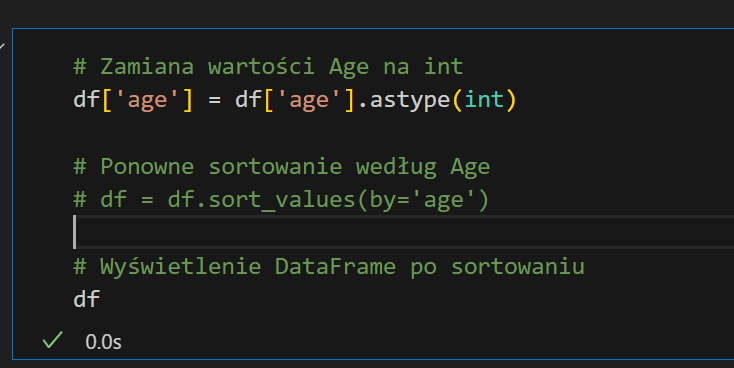

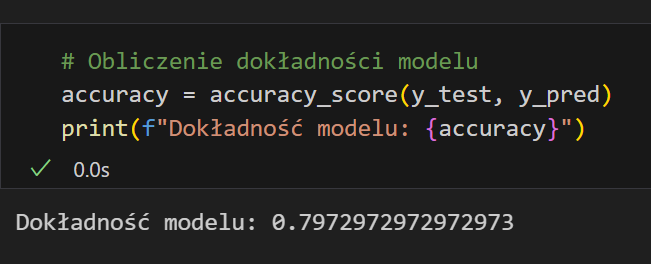

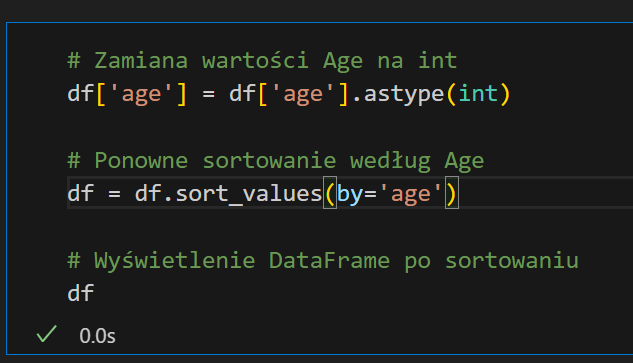

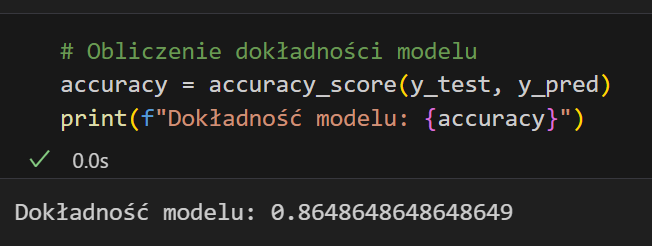